In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm

# module containing the main functions
import utils as ut

In [2]:
def stop_cond_memory(trajs, pars):
    """
    Stop condition of having the positive growth rate theta times smaller 
    than gamma
    """
    Ts, P, Ss = trajs[-1]
    growth_rates = pars.betas * P * (1 - Ss)
    gr_small_than_th = np.sum(growth_rates / pars.gamma < theta)
    return gr_small_than_th >= pars.n

def stop_cond_peak(trajs, pars):
    """
    Stop condition of being at the stationary point of total T cell abundance
    """
    if len(trajs) < 2: return False
    Ts1, _, _ = trajs[-1]
    Ts0, _, _ = trajs[-2]
    delta_T_tot = np.sum(Ts1) - np.sum(Ts0)
    return delta_T_tot < 0

def generate_ensamble(R, tau_sampler, stop_cond, **params):
    # Initializing parameters with default values or corrected through **params
    pars = ut.TT_params([1], **params)

    progress = tqdm(total=R)
    taus_mat, Tfreqs_mat, T_tot_mat, times_mat = [], [], [], []
    for _ in range(R):
        tau_sampler.sample()
        pars.set_taus(tau_sampler.taus)
        times, T_trajs, _, _ = ut.run_setting(pars, tau_sampler, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)
    
        T_tot_mat.append(np.sum(T_trajs, axis=1))
        times_mat.append(times)
        no_extinct = T_trajs[-1] >= 1
        freqs = T_trajs[-1] / T_trajs[-1].sum()
        Tfreqs_mat.append(freqs[no_extinct])
        taus_mat.append(tau_sampler.taus[no_extinct])
        progress.update(1)
        
    return taus_mat, Tfreqs_mat, T_tot_mat, times_mat

# Phase diagram varying $\tau_{crit}$ and $\alpha_0$ 
### Explaining the procedure step by step

In [ ]:
# Parameters kept fix 

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 100000, 'adapt', 30

# Memory stopping condition parameter (discussed below)
theta = 0.2  

# Fraction of ensambles with maximum to determine the non-monotoncity (discussed below)
no_max_perc = 0.8

# Minimal expansion factor
min_expans = 1.5

## Which time to use for computing the diagram observables?

#### Memory time

Condition: all the $T_i$ trajectories have a positive growth rate smaller than the constant death rate (memory phase when the expansion due to antigens is small):
$$
\beta_i P(t) (1 - S_i(t)) / \gamma < \theta 
$$
where $\theta$ is a threshold to be chosen.

In [32]:
pars = ut.TT_params(tau_samp.taus, alpha0=1e-3, tau_crit=1e-2)

times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, tau_samp, t_steps, dt, traj_steps=traj_steps, 
                                                  stop_cond=stop_cond_memory)

In [33]:
theta = 0.2
growth_rates = pars.betas[np.newaxis,:] * P_trajs[:,np.newaxis] * (1 - S_trajs)
gr_small_than_th = np.sum(growth_rates / pars.gamma < theta, axis=1)

time_memory_i = len(times) - np.sum(gr_small_than_th == pars.n)
if time_memory_i == len(times):
    print('memory time not reached')
else:
    time_memory = times[time_memory_i]
    print('Time at which the positive growth rate is "much" smaller than the death rate:', time_memory)

Time at which the positive growth rate is "much" smaller than the death rate: 16.2


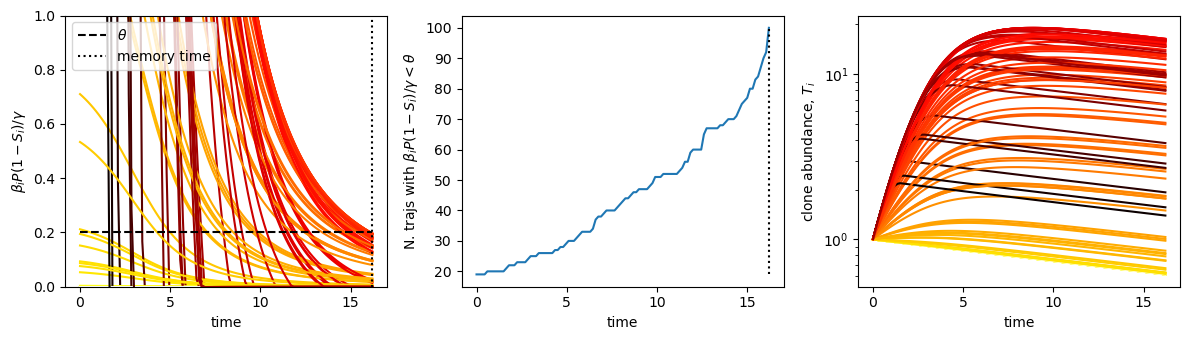

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 3.5))

cmap = colormaps.get_cmap('hot_r')
cmap_norm = plt.Normalize(vmin=min(np.log10(tau_samp.taus)), vmax=max(np.log10(tau_samp.taus)))

ax1.set_ylim(0,1)
ax1.set_ylabel(r'$\beta_i P (1 - S_i) / \gamma$')
ax1.set_xlabel('time')
for i, gr in enumerate(growth_rates.T):
    color = cmap(cmap_norm(np.log10(tau_samp.taus[i])))
    ax1.plot(times, gr/pars.gamma, c=color)
ax1.plot(times, theta * np.ones(len(times)), ls='--', c='k', label=r'$\theta$')
ax1.plot([time_memory, time_memory], [0, 1], ls=':', c='k', label='memory time')
ax1.legend()

ax2.set_ylabel(r'N. trajs with $\beta_i P (1 - S_i) / \gamma < \theta$')
ax2.set_xlabel('time')
ax2.plot(times, gr_small_than_th)
ax2.plot([time_memory, time_memory], [min(gr_small_than_th), pars.n], ls=':', c='k')

ax3.set_yscale('log')
ax3.set_xlabel('time')
ax3.set_ylabel(r'clone abundance, $T_i$')
for i, Ts in enumerate(T_trajs.T):
    color = cmap(cmap_norm(np.log10(tau_samp.taus[i])))
    ax3.plot(times, Ts, c=color)
    
plt.tight_layout()

#### Time of the peak

Stopping the simulation at the peak of global expansion

In [21]:
times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, tau_samp, t_steps, dt, traj_steps=traj_steps, 
                                                  stop_cond=stop_cond_peak)

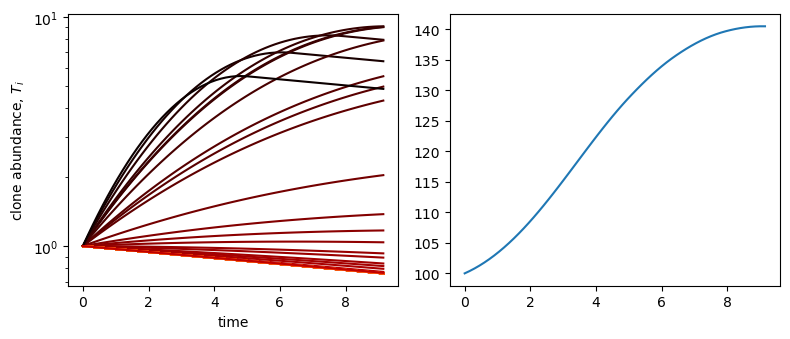

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5))

cmap = colormaps.get_cmap('hot_r')
cmap_norm = plt.Normalize(vmin=min(np.log10(tau_samp.taus)), vmax=max(np.log10(tau_samp.taus)))

ax1.set_yscale('log')
ax1.set_xlabel('time')
ax1.set_ylabel(r'clone abundance, $T_i$')
for i, Ts in enumerate(T_trajs.T):
    color = cmap(cmap_norm(np.log10(tau_samp.taus[i])))
    ax1.plot(times, Ts, c=color)

T_tot = np.sum(T_trajs, axis=1)
ax2.plot(times, T_tot)
    
plt.tight_layout()

## Detecting the maximum of abundance-affinity plot in an ensemble

The most consistent way of doing it seems to use the ensamble of trajectories of the derivative and check when it crosses the zero.

I tried also by using the scatter plot of all the points tau-T generated in the ensamble, but this cloud seems to bias the position of the maximum and I can find fake maximums also in case of alpha0 = 0.

Procedure to compute maximum which returns $x_{max}$, $y_{max}$ and $n{max}$ (how many trajectories show a max):
- Generate $R$ systems with given parameters and obtain the $\tau_i$-$f_i$ scatter ($f_i$ is the fraction of cells in clone $i$).
- Log transform the two variables: $x_i = \log_{10} \tau_i$,  $y_i = \log_{10} f_i$.
- Compute the curve of the slopes between consecutive points: $d_i = \Delta y_i / \Delta x_i$.
- Compute the average of this ensemble of trajectories $d_i$-$x_i$ and find the point where it crosses 0, this gives $x_{max}$.
- Count how many maxima have been found $n_{max}$ by looking if the single trajectory contains the position $x_{max}$ and if it ends as a decreasing function.
- For the trajectories that have a max (condition above) compute the intersection at $x_{max}$ to get $y_{max,i}$ and the average to get $y_{max}$.
- 
Condition to exclude an ensemble maximum:
- If the fraction of trajectories not having a max is larger than `no_max_perc` then the ensamble is considered **monotonous increasing**.
- If the average total number of receptors at maximum is smaller that `min_expans` * number of initial receptors, than the ensamble is considered **not expanding**. 

In [14]:
def find_first_zero(xs, ys):
    for i in range(1, len(xs)):
        x0, y0, x1, y1 = xs[i-1], ys[i-1], xs[i], ys[i]
        if y0*y1 < 0:
            # Linear interpolation to get the zero
            x_max = x1 + y1*(x0-x1)/(y1-y0)
            return x_max
    return float('nan')


def find_max(taus_mat, Tfreqs_mat, smooth_bins=30):
    """
    Method for detecting an average maximum in an ensemble of tau-freq curves
    """
    if any(np.array([len(t) < 2 for t in taus_mat])):
        return float('nan'), float('nan'), 0, 'extinct'
    
    # Moving to the log transformed variables, sorting them and taking the derivative
    logtaus, logTfreq = [np.log10(t) for t in taus_mat], [np.log10(t) for t in Tfreqs_mat]
    tau_sort_i = [np.argsort(t) for t in logtaus]
    logtaus = [logtaus[i][tau_sort_i[i]] for i in range(len(logtaus))]
    logTfreq = [logTfreq[i][tau_sort_i[i]] for i in range(len(logTfreq))]
    ders = [(logTfreq[i][1:] - logTfreq[i][:-1]) / (logtaus[i][1:] - logtaus[i][:-1]) for i in range(len(logtaus))]
    mid_logtaus = [(logtaus[i][1:] + logtaus[i][:-1]) / 2.0 for i in range(len(logtaus))]

    # Computing the average trajectory
    bins = np.linspace(np.min(np.concatenate(mid_logtaus)), np.max(np.concatenate(mid_logtaus)), smooth_bins)
    smooth_x, smooth_y, _, _ = ut.binning_x(np.concatenate(mid_logtaus), np.concatenate(ders), bins)

    # Finding the zero of the smoothed trajectory
    x_max = find_first_zero(smooth_x, smooth_y)
    if np.isnan(x_max):
        return x_max, float('nan'), 0, 'no_maximum'

    # Counting how many trajectories cross the average maximum and are decreasing at the end
    logtaus_end = np.array([t[-1] for t in logtaus])
    ders_end = np.array([d[-1] for d in ders])
    max_mask = np.logical_and(logtaus_end > x_max, ders_end < 0)
    n_x_max = np.sum(max_mask)
    
    # Estimating the average y at max
    y_maxs = []
    for r in range(len(taus_mat)):
        if max_mask[r]:
            y_maxs.append(np.interp(x_max, logtaus[r], logTfreq[r]))
    y_max = np.mean(y_maxs)
    
    return x_max, y_max, n_x_max, 'maximum'


def evaluate_max_result(x_max, n_x_max, no_max_perc, verbose=False):
    #if y_max < np.log10(min_freq_max):
    #    if verbose: print('Maximum at almost minimal frequecy')
    #    y_max = float('nan')
    if ((R - n_x_max) / R > no_max_perc):
        print('Not enough trajectories have a max')
        x_max = float('nan')
    return x_max
    

def plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, T_tot, times, smooth_bins=30, xlim=None):
    """
    Plotting derivatives and logT vs. logtau trajectories with the identified maximum
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(11,3))
    
    ax1.set_ylabel(r'$\Delta \log_{10} T / \Delta \log_{10} \tau$')
    ax1.set_xlabel(r'affinity, $\log_{10}\tau_i$')

    if xlim is not None:
        ax1.set_xlim(xlim)
        ax2.set_xlim(xlim)
    
    logtaus, logTfreq = [np.log10(t) for t in taus_mat], [np.log10(t) for t in Tfreqs_mat]
    tau_sort_i = [np.argsort(t) for t in logtaus]
    logtaus = [logtaus[i][tau_sort_i[i]] for i in range(len(logtaus))]
    logTfreq = [logTfreq[i][tau_sort_i[i]] for i in range(len(logTfreq))]
    ders = [(logTfreq[i][1:] - logTfreq[i][:-1]) / (logtaus[i][1:] - logtaus[i][:-1]) for i in range(len(logtaus))]
    mid_logtaus = [(logtaus[i][1:] + logtaus[i][:-1]) / 2.0 for i in range(len(logtaus))]
    bins = np.linspace(np.min(np.concatenate(mid_logtaus)), np.max(np.concatenate(mid_logtaus)), smooth_bins)
    smooth_x, smooth_y, _, _ = ut.binning_x(np.concatenate(mid_logtaus), np.concatenate(ders), bins)
    
    for r in range(R):
        ax1.plot(mid_logtaus[r], ders[r], c='b', alpha=0.2)
    ax1.plot(smooth_x, smooth_y, c='r', label='average')
    xs = np.linspace(np.min(np.concatenate(mid_logtaus)), np.max(np.concatenate(mid_logtaus)), 2)
    ax1.plot(xs, np.zeros(len(xs)), c='k', ls=':')
    ys = np.linspace(np.min(np.concatenate(ders)), np.max(np.concatenate(ders)), 2)
    ax1.plot([x_max, x_max], ys, c='k', label='maximum x')
    ax1.legend()
    
    ax2.set_ylabel(r'clone log frequency $\log_{10} T_i$')
    ax2.set_xlabel(r'affinity, $\log_{10}\tau_i$')
    for r in range(R):
        ax2.plot(logtaus[r], logTfreq[r], c='b', alpha=0.2)
    ys = np.linspace(np.min(np.concatenate(logTfreq)), np.max(np.concatenate(logTfreq)), 2)
    ax2.plot([x_max, x_max], ys, c='k')
    ax2.plot(xs, np.ones(len(xs))*y_max, c='k', ls='--')
    
    for i in range(len(times)):
        ax3.plot(times[i], T_tot[i], c='g', alpha=0.2)
    ax3.set_xlabel(r'time')
    ax3.set_ylabel(r'total response, $T_{tot}$')

    return ax1, ax2, ax3

#### Case with a clear maximum

In [ ]:
R = 200
taus_mat, Tfreqs_mat, T_tot_mat, times_mat = generate_ensamble(R, tau_samp, stop_cond_memory, alpha0=1e-4, tau_crit=1)
x_max, y_max, n_x_max, outcome = find_max(taus_mat, Tfreqs_mat)

x_max = evaluate_max_result(x_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max, n_x_max/R, outcome)

100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


0.41016609933768094 -0.7287836546102854 0.815 358.66943237785995


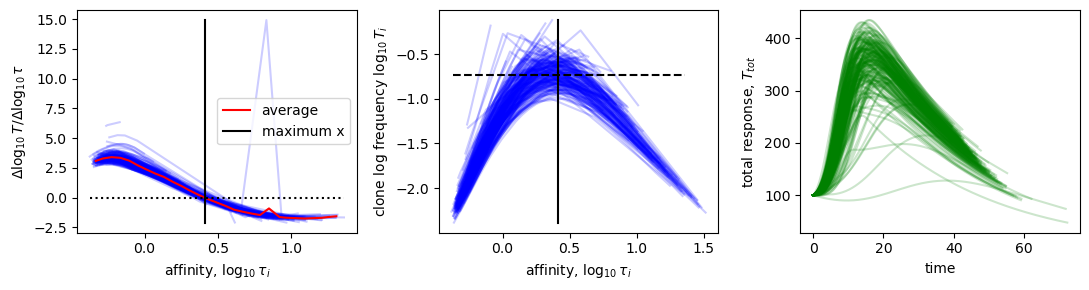

In [8]:
ax1, ax2, ax3 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, T_tot_mat, times_mat)
plt.tight_layout()

#### Case with many trajectories not having a maximum 
Some trajectories show a maximum, some others do not. I trust the maximum only if the number not showing a max is smaller than `no_max_perc`

In [ ]:
R = 200
taus_mat, Tfreqs_mat, T_tot_mat, times_mat = generate_ensamble(R, tau_samp, stop_cond_memory, alpha0=1e-5)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max = evaluate_max_result(x_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max, n_x_max/R, outcome)

  0%|          | 1/200 [00:00<00:20,  9.83it/s]

100%|██████████| 200/200 [00:20<00:00,  9.56it/s]

0.9790295562325604 -0.5768571244428788 0.295 644.4440420182331


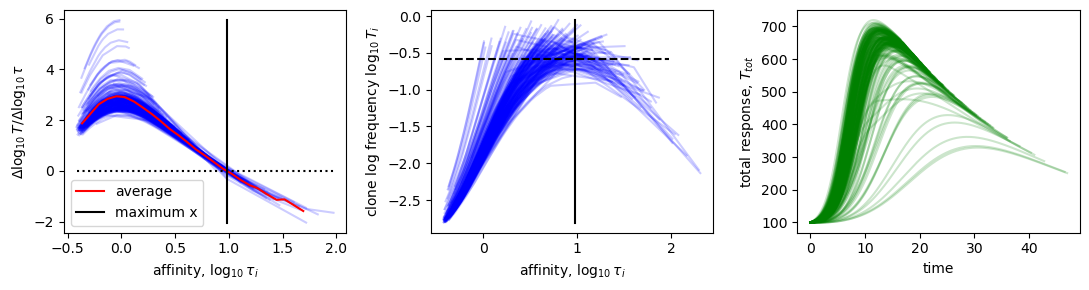

In [10]:
ax1, ax2, ax3 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, T_tot_mat, times_mat)
plt.tight_layout()

#### Always increasing case for small inhibition
Mote that some trajectories can still have a very large max affinity that show a maximum, but their fraction should be smaller that the threshold `no_max_perc`

In [ ]:
R = 200
taus_mat, Tfreqs_mat, T_tot_mat, times_mat = generate_ensamble(R, tau_samp, stop_cond_memory, alpha0=1e-6)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max = evaluate_max_result(x_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max, outcome)

100%|██████████| 200/200 [00:16<00:00, 12.16it/s]

Not enough trajectories have a max
nan nan 692.2667170796539


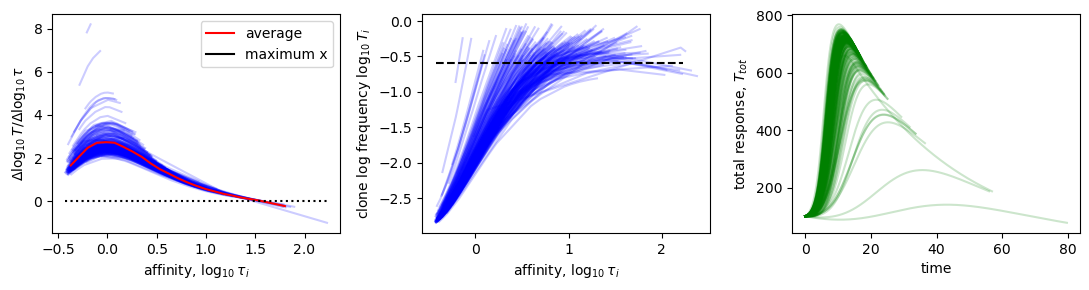

In [11]:
ax1, ax2, ax3 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, T_tot_mat, times_mat)
plt.tight_layout()

#### Strong inhibition

With too much inhibition the procedure still finds a maximum due to the noisy behavior of the trajectories even if it does not look like a max anymore.
However we can use $y_{max}$ to say that this is not really a max, because $y_{max} \approx 1/N$, and therefore those are almost extinct clones.

In [24]:
R = 200
#taus_mat, Tfreqs_mat, T_tot_mat, times_mat = generate_ensamble(R, tau_samp, stop_cond_memory, alpha0=1e-2)
x_max, y_max, n_x_max = find_max(taus_mat, Tfreqs_mat)

x_max, y_max = evaluate_max_result(x_max, y_max, n_x_max, no_max_perc, verbose=True)
print(x_max, y_max, np.mean([np.max(Ttot) for Ttot in T_tot_mat]))

Maximum at almost minimal frequecy
0.006052596511739644 nan 100.16360296815753


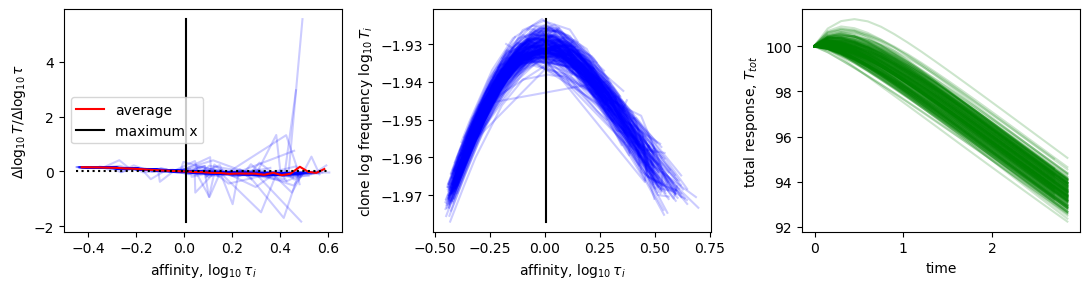

In [19]:
ax1, ax2, ax3 = plot_max_procedure(taus_mat, Tfreqs_mat, x_max, y_max, T_tot_mat, times_mat)
plt.tight_layout()